## Test a VGG network with mean normalized spectrograms

In [69]:
##### ##### CNN Parameters #####

batch_size = 20 
epochs = 60
mean_norm = True        # Flag to determine whether to use standard spectrograms or mean-normalized set
pad_images = False       # Resize images to a square by padding the end with gray (before resizing)
image_height_width = 149  # Resize all images to square with this height and width

###########################

In [27]:
# Load packages

import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import IPython.display as ipd
from numpy.lib import stride_tricks
import os
from PIL import Image
import scipy.io.wavfile as wav

import keras
from keras import regularizers
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Sequential


%matplotlib inline

## 1) Load and Filter Data

In [3]:
# Load master index, and filter and assign to train and test using pandas

# *** Load prompt_id as text with leading zeros
df = pd.read_csv('../index_TORGO.txt', sep="|", converters={'prompt_id': lambda x: str(x)})

# Remove instances where prompt is None OR prompts that begin with "[" or contain "jpg" OR where has_spect is No
df['remove'] = (df['prompt']==None) | (df['prompt']=='None') | (df['prompt'].str.contains('jpg')) | (df['prompt'].str.startswith('[')) | (df['has_spect']=='No')

print('Number of rows:', df.shape[0])
print('Number of rows set to remove:', df[df['remove']==True].shape[0])
df.head(20)

Number of rows: 6179
Number of rows set to remove: 523


,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove
0,F01,Session1,wav_headMic,0001,yes,320,513,[say Ah-P-Eee repeatedly],True
1,F01,Session1,wav_headMic,0002,yes,295,513,[say Ah-P-Eee repeatedly],True
2,F01,Session1,wav_headMic,0003,yes,242,513,[say Pah-Tah-Kah repeatedly],True
3,F01,Session1,wav_headMic,0004,yes,301,513,[say Eee-P-Ah repeatedly],True
4,F01,Session1,wav_headMic,0005,yes,240,513,[relax your mouth in its normal position],True
5,F01,Session1,wav_headMic,0006,yes,44,513,stick,False
6,F01,Session1,wav_headMic,0007,yes,71,513,tear [as in tear up that paper],False
7,F01,Session1,wav_headMic,0008,yes,308,513,Except in the winter when the ooze or snow or ...,False
8,F01,Session1,wav_headMic,0009,yes,40,513,pat,False
9,F01,Session1,wav_headMic,0010,yes,65,513,up,False


In [4]:
# Only keep instances where the recording was made on both the head and array mics
df = df[df['remove']==False]

df_head = df[(df['mic']=='wav_headMic')]
df_array = df[(df['mic']=='wav_arrayMic')]

df_filter = pd.merge(df_head, df_array, on=['speaker','session','prompt_id'])
print('Number of rows after filter and join in filter df:', df_filter.shape[0])
keep_id = df_filter['speaker'] + df_filter['session'] + df_filter['prompt_id']

df['keep_id'] = df['speaker'] + df['session'] + df['prompt_id']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after filter and join in df:', df.shape[0])  # Should be 2x the rows in the filter df

Number of rows after filter and join in filter df: 2471
Number of rows after filter and join in df: 4942


In [5]:
# Only keep instances where a prompt was recorded more than once

df_filter = df.groupby(['speaker','mic','prompt']).size().reset_index(name='counts')
df_filter = df_filter[df_filter['counts']>1]
keep_id = df_filter['speaker'] + df_filter['prompt']

df['keep_id'] = df['speaker'] + df['prompt']
df = df[df.keep_id.isin(keep_id)]
print('Number of rows after removing prompts only recorded once:', df.shape[0])

Number of rows after removing prompts only recorded once: 1422


In [6]:
df = df.sort_values(by=['speaker','prompt','prompt_id','mic'])
df.head(10)

,speaker,session,mic,prompt_id,has_spect,spect_width,spect_height,prompt,remove,keep_id
163,F01,Session1,wav_arrayMic,0030,yes,165,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
29,F01,Session1,wav_headMic,0030,yes,151,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
164,F01,Session1,wav_arrayMic,0031,yes,155,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
30,F01,Session1,wav_headMic,0031,yes,145,513,The quick brown fox jumps over the lazy dog.,False,F01The quick brown fox jumps over the lazy dog.
148,F01,Session1,wav_arrayMic,0015,yes,57,513,air,False,F01air
14,F01,Session1,wav_headMic,0015,yes,67,513,air,False,F01air
212,F01,Session1,wav_arrayMic,0079,yes,61,513,air,False,F01air
78,F01,Session1,wav_headMic,0079,yes,39,513,air,False,F01air
162,F01,Session1,wav_arrayMic,0029,yes,57,513,beat,False,F01beat
28,F01,Session1,wav_headMic,0029,yes,50,513,beat,False,F01beat


## 2) Assign Data to Test and Train Sets

In [7]:
# Using the head Mic data, Sort the df by speaker, prompt, and prompt id
# Alternate assigning each row to train and test
# Then use that to join the assignment to the main dataframe, in order to tag the array Mic data with train/test

df_filter = df[df['mic']=='wav_headMic'].sort_values(by=['speaker','prompt','prompt_id'])

df_filter['train'] = 0
train = 1
for index, row in df_filter.iterrows():
    df_filter.at[index,'train'] = train
    train *= -1

df_filter = df_filter[['speaker','session','prompt_id','train']]

df = pd.merge(df, df_filter, on=['speaker','session','prompt_id'])

In [8]:
# *** FOR NOW ONLY USE FEMALE 1 *** We can alter this later
df = df[df['speaker']=='F01']

# Add numerical prompt codes once final data set is compiled
df.prompt = pd.Categorical(df.prompt)
df['prompt_code'] = df.prompt.cat.codes

df.head(80)

num_classes = df['prompt_code'].max() + 1
print('Number of rows for Female 1:', df.shape[0])
print('Number of unique prompts for Female 1: ', num_classes)

Number of rows for Female 1: 78
Number of unique prompts for Female 1:  18


## 3) Create required image lists - remember to re-run this if you change the mean_norm flag

In [9]:
# Get all predictor variables (padded images) and outcome variable (prompt)
images = []
prompts = []
train = []

for index, row in df.iterrows():
    if mean_norm:
        img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'_n.png'])
    else:
        img_loc = '/'.join(['../data/TORGO', row['speaker'], row['session'], row['mic']+'_spect', row['prompt_id']+'.png'])
    img = cv2.imread(img_loc, 0)

    # Pad images before resize
    if pad_images:
        PADCOLOR = 132
        pad = maxwidth - img.shape[1] # pad width with gray
        img_new = cv2.copyMakeBorder(img,0,0,0,pad,cv2.BORDER_CONSTANT,value=PADCOLOR)
        pad = maxwidth - img.shape[0] # pad height with replication
        img_new = cv2.copyMakeBorder(img_new,0,pad,0,0,cv2.BORDER_WRAP)
        images.append(img_new)
    # Do not pad images before resize
    else:
        images.append(img)

    prompts.append(row['prompt_code'])
    train.append(row['train'])

In [10]:
# View first 10 records, and verify image sizes
print(prompts[0:10])
print(train[0:10])

for i in images[0:10]:
    print(i.shape)

[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]
[1, 1, -1, -1, 1, 1, -1, -1, 1, 1]
(513, 165)
(513, 151)
(513, 155)
(513, 145)
(513, 57)
(513, 67)
(513, 61)
(513, 39)
(513, 57)
(513, 50)


(<matplotlib.axes._subplots.AxesSubplot at 0x117247908>,
 <matplotlib.image.AxesImage at 0x11718d748>)

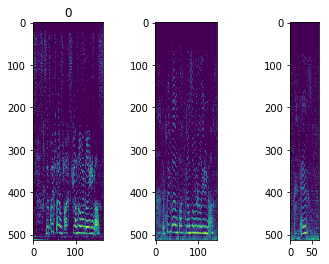

In [11]:
# See what they look like to visualize size and padding
plt.subplot(131), plt.imshow(images[0]), plt.title(prompts[0])
plt.subplot(132), plt.imshow(images[3])
plt.subplot(133), plt.imshow(images[5])


(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)
(149, 149)


(<matplotlib.image.AxesImage at 0xb3256acc0>,
 Text(0.5,1,'AFTER PADDING and SHRINK'))

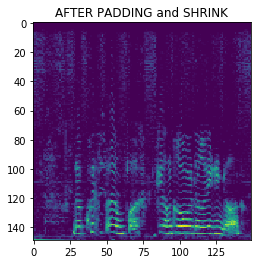

In [12]:
# Resize Images to image_height_width, which is set in the first cell of this workbook
maxwidth = image_height_width

images_shrunk = []
for i in images:
    images_shrunk.append(cv2.resize(i, (maxwidth, maxwidth)))

images = images_shrunk
for i in images[0:10]:
    print(i.shape)

plt.imshow(images[0]),plt.title('AFTER PADDING and SHRINK')

(<matplotlib.axes._subplots.AxesSubplot at 0xb32b82ac8>,
 <matplotlib.image.AxesImage at 0xb32bd8358>)

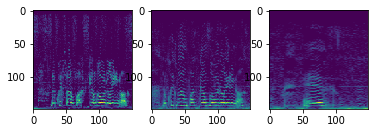

In [13]:
# See what they look like now, after rescaling
plt.subplot(131), plt.imshow(images[0])
plt.subplot(132), plt.imshow(images[3])
plt.subplot(133), plt.imshow(images[5])


## 4) Set up and run CNN

Recreated this CNN using Keras. [See here](https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/). In this workbook, we're going to try out a DNN architecture described [here](https://blogs.technet.microsoft.com/machinelearning/2018/01/30/hearing-ai-getting-started-with-deep-learning-for-audio-on-azure/), which is similar to a VGG network.  
  
![](architecture.png)

In [14]:
# Split data into training and testing
x_train_pre = np.array([images[i] for i,x in enumerate(train) if x==1])
y_train_pre = np.array([prompts[i] for i,x in enumerate(train) if x==1])
x_test_pre = np.array([images[i] for i,x in enumerate(train) if x==-1])
y_test_pre = np.array([prompts[i] for i,x in enumerate(train) if x==-1])

x_train = x_train_pre
y_train = y_train_pre
x_test = x_test_pre
y_test = y_test_pre

print('Number of training records:', len(y_train))
print('Number of test records:', len(y_test))

Number of training records: 40
Number of test records: 38


In [15]:
# input image dimensions
img_x, img_y = maxwidth, maxwidth

In [16]:
# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because it is in greyscale, we only have a single channel - RGB colour images would have 3
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

In [17]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (40, 149, 149, 1)
40 train samples
38 test samples


In [18]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

In [70]:
# Build CNN

model = Sequential()

# section 1 Two conv layers plus max pooling with dropout
model.add(Conv2D(filters=32, kernel_size=5,
                        strides=2,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal",
                        input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))


# section 2 Another two conv layers plus max pooling with dropout
model.add(Conv2D(filters=64, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# section 3 Four conv layers plus max pooling and dropout
model.add(Conv2D(filters=128, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(Conv2D(filters=128, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(Conv2D(filters=128, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(Conv2D(filters=128, kernel_size=3,
                        strides=1,
                        padding="same",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# section 4 Two conv layers with dropout
model.add(Conv2D(filters=512, kernel_size=3,
                        strides=1,
                        padding="valid",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=1,
                        strides=1,
                        padding="valid",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# section 5 Final conv layer, global pooling layer and softmax
model.add(Conv2D(filters=num_classes, kernel_size=1,
                        strides=1,
                        padding="valid",
                        activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001),
                        kernel_initializer="normal"))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))


In [71]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [72]:
history = AccuracyHistory()

In [73]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 40 samples, validate on 38 samples
Epoch 1/60
40/40 [==============================] - 8s 200ms/step - loss: 3.2204 - acc: 0.0500 - val_loss: 3.3102 - val_acc: 0.0526
Epoch 2/60
40/40 [==============================] - 3s 64ms/step - loss: 3.1405 - acc: 0.1500 - val_loss: 3.2529 - val_acc: 0.0526
Epoch 3/60
40/40 [==============================] - 3s 64ms/step - loss: 3.1270 - acc: 0.1750 - val_loss: 3.2417 - val_acc: 0.0789
Epoch 4/60
40/40 [==============================] - 3s 65ms/step - loss: 3.0590 - acc: 0.2000 - val_loss: 3.2175 - val_acc: 0.1053
Epoch 5/60
40/40 [==============================] - 3s 65ms/step - loss: 3.0101 - acc: 0.3000 - val_loss: 3.1883 - val_acc: 0.1053
Epoch 6/60
40/40 [==============================] - 3s 64ms/step - loss: 2.9224 - acc: 0.2750 - val_loss: 3.1905 - val_acc: 0.1053
Epoch 7/60
40/40 [==============================] - 3s 65ms/step - loss: 2.8961 - acc: 0.3750 - val_loss: 3.2267 - val_acc: 0.1053
Epoch 8/60
40/40 [====================

With mean normalization
Test loss: 3.6899600279958626
Test accuracy: 0.23684210604742953


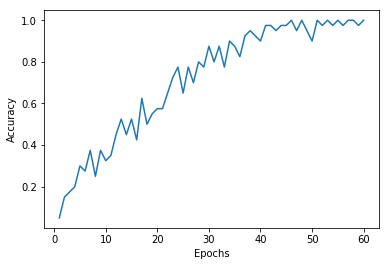

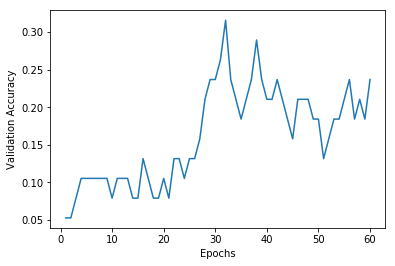

In [74]:
# Results with mean normalization

print('With mean normalization')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(1, epochs + 1), history.val_acc)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

### Notes on results:

Although the curve for the test data looks pretty good, the model remains poor on the validation data. Since we know this is a model that performs well on sound identification tasks, I think it means that our issue might be  
* suboptimal feature representation (eg may need to use MFCC's instead of raw spectrograms)
* lack of training data  

or more likely a combination of the two
